<a href="https://colab.research.google.com/github/kangelaa/honors-thesis/blob/main/HThesis_SVMModel_HudetzHoldout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Honors Thesis: Classifying Consciousness
by Angela Kan


In [ ]:
#required imports
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, backend
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as spio
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm 
from statistics import mean, variance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from scipy import stats
import pandas as pd

#print full array setting
np.set_printoptions(threshold=1000) #revert back to regular w/ threshold=1000

## Data Imports, Preprocessing, Splitting


In [ ]:
#access STSP .mat files from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

PREPROCESSING FOR NEW DATA (same lengths):

In [34]:
#SAME LENGTH VERSION - PROPOFOL DATA
#import files and save in dataframe, adding labels 

NUM_SUBJECTS=18
NUM_SCANS=38 #25 w/o recovery data
LARGEST_X_DIM=55
LARGEST_Y_DIM=100

#array initialized w/ 0s for image data 
all_data=np.zeros((NUM_SCANS,LARGEST_X_DIM*LARGEST_Y_DIM))
#array initialized w/ 2s for label data (0 for wake, 1 for sleep)
all_labels=np.ones((NUM_SCANS))*3 #initialize with 3's

#iterate through each STSP
for i in range(1,1+NUM_SCANS):
  if i < 10:
    mat=spio.loadmat(f"/content/gdrive/MyDrive/2022-23/Honors Thesis/propofol_stsps/_fft_stsp_sub_00{i}.mat")
  else:
    mat=spio.loadmat(f"/content/gdrive/MyDrive/2022-23/Honors Thesis/propofol_stsps/_fft_stsp_sub_0{i}.mat")
  stsp = mat["stsp"]
  #cropped = stsp[:,:100]  #crop accordingly
  flat = stsp.flatten() #remove structure for SVM input
  all_data[i-1]=flat

  # #create labels dataframe
  # if i % 2 == 0: # even=wakefulness state, add label [0]
  #   all_labels[i-1]=0
  # else: # odd=sleep state, add label [1] 
  #   all_labels[i-1]=1


#reshape to be 4dim from 3dim
#all_data=np.reshape(all_data,(NUM_SUBJECTS*2,LARGEST_X_DIM,LARGEST_Y_DIM,1))

In [28]:
#SAME LENGTH VERSION - HUDETZ DATA
#import files and save in dataframe, adding labels 

NUM_SCANS=43 
LARGEST_X_DIM=55
LARGEST_Y_DIM=100

#array initialized w/ 0s for image data 
all_test_data=np.zeros((NUM_SCANS,LARGEST_X_DIM*LARGEST_Y_DIM))
#array initialized w/ 2s for label data (0 for wake, 1 for sleep)
all_test_labels=np.ones((NUM_SCANS))*3 #initialize with 3's

#iterate through each STSP
for i in range(1,1+NUM_SCANS):
  if i < 10:
    mat=spio.loadmat(f"/content/gdrive/MyDrive/2022-23/Honors Thesis/hudetz_stsps/_fft_stsp_sub_00{i}.mat")
  else:
    mat=spio.loadmat(f"/content/gdrive/MyDrive/2022-23/Honors Thesis/hudetz_stsps/_fft_stsp_sub_0{i}.mat")
  stsp = mat["stsp"]
  #cropped = stsp[:,:100]  #crop accordingly
  flat = stsp.flatten() #remove structure for SVM input
  all_test_data[i-1]=flat

In [29]:
#set HUDETZ labels based on info
info_hud=spio.loadmat(f"/content/gdrive/MyDrive/2022-23/Honors Thesis/hudetz_stsps/_fft_info.mat")
#recovery_hud = []
wake_hud=[]
unconscious_hud=[]
for i, name in enumerate(info_hud["fft4info"]["images"][0][0]):
  if 'Wakefulness' in str(name[0]):
    all_test_labels[i]=0
    wake_hud.append(i)
  elif 'DeepSedation' in str(name[0]):
    all_test_labels[i]=1
    unconscious_hud.append(i)
  # elif 'W2' in str(name[0]):
  #   all_labels[i]=2 #make 0 or 2 depending on # of classes desired
  #   recovery_hud.append(i)

In [35]:
#set PROPOFOL labels based on info
info_prop=spio.loadmat(f"/content/gdrive/MyDrive/2022-23/Honors Thesis/propofol_stsps/_fft_info.mat")
recovery_prop = []
wake_prop=[]
unconscious_prop=[]
for i, name in enumerate(info_prop["fft4info"]["images"][0][0]):
  if 'W1' in str(name[0]):
    all_labels[i]=0
    wake_prop.append(i)
  elif 'S2' in str(name[0]):
    all_labels[i]=1
    unconscious_prop.append(i)
  elif 'W2' in str(name[0]):
    all_labels[i]=2 #make 0 or 2 depending on # of classes desired
    recovery_prop.append(i)

In [36]:
#drop prop recovery data if desired (for more balanced dataset)
for scan in info_hud["fft4info"]["images"][0][0]:
  print(scan[0])

#print(recovery_prop)

all_data=np.delete(all_data,recovery_prop,axis=0)
all_labels=np.delete(all_labels,recovery_prop,axis=0)


['/Volumes/T7Shield/Hudetz_STSP/res2std_cropped/C1_P1_Wakefulness_res2std.nii']
['/Volumes/T7Shield/Hudetz_STSP/res2std_cropped/C1_P2_DeepSedation_res2std.nii']
['/Volumes/T7Shield/Hudetz_STSP/res2std_cropped/C1_P2_Wakefulness_res2std.nii']
['/Volumes/T7Shield/Hudetz_STSP/res2std_cropped/C1_P3_DeepSedation_res2std.nii']
['/Volumes/T7Shield/Hudetz_STSP/res2std_cropped/C1_P3_Wakefulness_res2std.nii']
['/Volumes/T7Shield/Hudetz_STSP/res2std_cropped/C1_P4_Wakefulness_res2std.nii']
['/Volumes/T7Shield/Hudetz_STSP/res2std_cropped/C1_P5_Wakefulness_res2std.nii']
['/Volumes/T7Shield/Hudetz_STSP/res2std_cropped/C1_P6_DeepSedation_res2std.nii']
['/Volumes/T7Shield/Hudetz_STSP/res2std_cropped/C1_P6_Wakefulness_res2std.nii']
['/Volumes/T7Shield/Hudetz_STSP/res2std_cropped/C1_P7_DeepSedation_res2std.nii']
['/Volumes/T7Shield/Hudetz_STSP/res2std_cropped/C1_P7_Wakefulness_res2std.nii']
['/Volumes/T7Shield/Hudetz_STSP/res2std_cropped/C1_P11_DeepSedation_res2std.nii']
['/Volumes/T7Shield/Hudetz_STSP/re

In [37]:
#reset index for each class
wake_prop=[]
unconscious_prop=[]
for i, name in enumerate(all_labels):
  if name==0:
    #all_labels[i]=0
    wake_prop.append(i)
  elif name==1:
    #all_labels[i]=1
    unconscious_prop.append(i)


UNDERSAMPLING

In [38]:
#DROP unusable subjects from data
# DROP_sub = [7,8,9,10,13,14,17,18,19,20,21,22,27,28,31,32,33,34]
# DROP_bad = #[8,10,18,19,21,22,27,28,31,32,33] #THESE SHOULD BE MOVED BACK ONE INDEX? 0-indexing (CHECK ORDER AGAIN, added in order of info.mat)

# all_data=np.delete(all_data,DROP_bad,axis=0)
# all_labels=np.delete(all_labels,DROP_bad,axis=0)

#BALANCE TRAIN DATA 
drop_prop_wake=resample(wake_prop,replace=False,n_samples=3)
#DROP_bad = [17,19,22]
#DROP_bad = #[8,10,18,19,21,22,27,28,31,32,33] #THESE SHOULD BE MOVED BACK ONE INDEX? 0-indexing (CHECK ORDER AGAIN, added in order of info.mat)

all_data=np.delete(all_data,drop_prop_wake,axis=0)
all_labels=np.delete(all_labels,drop_prop_wake,axis=0)
drop_prop_wake

[19, 15, 22]

In [ ]:
1#only use C2 for Hudetz test 
# all_test_data=all_test_data[:23]
# all_test_labels=all_test_labels[:23]

OVERSAMPLING (potential risk of overfitting?) 

NOTE: USING RANDOM SEED

In [ ]:
#sample 3 more datapoints for balanced dataset
unconscious_upsample_index = resample(unconscious_prop,replace=True, n_samples=len(wake_prop)-len(unconscious_prop),random_state=1234)
unconscious_upsample_index


In [ ]:
unconscious_upsample_index = np.concatenate([unconscious_upsample_index,unconscious_prop])
unconscious_upsample_index

In [ ]:
unconscious_upsample=[all_data[i] for i in unconscious_upsample_index]
unconscious_labels=np.ones(len(unconscious_upsample))

wake_data=[all_data[i] for i in wake_prop]
wake_labels=np.zeros(len(wake_data))

#unconscious_upsample,unconscious_labels,wake_data,wake_labels

In [ ]:
all_data=np.concatenate([np.array(wake_data),np.array(unconscious_upsample)])
all_labels=np.concatenate([wake_labels,unconscious_labels])


In [ ]:
all_labels

In [ ]:
print(all_data.shape,all_labels.shape)
all_data,all_labels

In [40]:
sum(all_labels),len(all_labels)

(11.0, 22)

In [ ]:
print(all_test_data.shape,all_test_labels.shape)
all_test_data,all_test_labels

In [39]:
sum(all_test_labels),len(all_test_labels)

(16.0, 43)

Display STSP data

In [ ]:
# mat=spio.loadmat("/content/gdrive/MyDrive/2022-23/Honors Thesis/hudetz_stsps/_fft_stsp_sub_001.mat")
# data=mat["stsp"]
# plt.imshow(data)

In [41]:
#split into training/validation and testing, with specified test_size split and ensuring both train/test have same amount of sleep/wake data
# TEST_SIZE=.3

# #train-test split from all_data
# x_train,x_test,y_train,y_test=train_test_split(all_data,all_labels,test_size=TEST_SIZE,stratify=all_labels)
# print(x_train.shape,x_test.shape)

#train-val split for train data
# x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=TEST_SIZE,#random_state=1234,stratify=y_train)
# print(x_train.shape,x_val.shape,y_train,y_val)
# print(x_train[2])

# #train-test split from all_data
# x_train,x_test,y_train,y_test=train_test_split(all_data,all_labels,test_size=TEST_SIZE,stratify=all_labels)
# print(x_train.shape,x_test.shape)

#train-test split from all_data AND all_test_data
x_train,x_test,y_train,y_test=all_data,all_test_data,all_labels,all_test_labels
print(x_train.shape,x_test.shape)

(22, 5500) (43, 5500)


In [ ]:
# #normalize data: Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network.
# x_train=np.array((x_train-np.min(x_train))/(np.max(x_train)-np.min(x_train)))
# x_test = np.array((x_test-np.min(x_test))/(np.max(x_test)-np.min(x_test)))
# x_train=x_train/np.std(x_train)
# x_test=x_test/np.std(x_test)
# x_train,x_test

In [ ]:
#plt.imshow(mat["stsp"])

Let's take a look at our dataset. 

In [ ]:
train_labels=["wake","unconscious"]#,"recovery"]

In [ ]:
plt.figure(figsize=(10,10))

for i in range(20): #loop through grid, plot each image
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

  plt.imshow(x_train[i])
  plt.xlabel(train_labels[int(y_train[i])]) #label w/ class names 
plt.show()


## Building a Model

MRMR (https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b) 

SVMS advantages (https://scikit-learn.org/stable/modules/svm.html):
- effective in high dimensional spaces
- effective where # of dimensions > number of samples


In [ ]:
#!pip install mrmr_selection 
from mrmr import mrmr_classif

selected_features=mrmr_classif(x_train,y_train,K=10)

### Leave One Out Implementation

In [ ]:
#leave one data point out at a time

#SVM
svm_accuracy = []
svm_params = []

for i in range(len(all_data)):
  train_x = np.delete(all_data,i,axis=0)
  train_y = np.delete(all_labels,i)
  test_x = all_data[i]
  test_y = all_labels[i]

  param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','linear','poly']}
  svc=svm.SVC()
  model=GridSearchCV(svc,param_grid) #can print cv_results_ attribute of gridsearch model if desired!
  model.fit(train_x,train_y)
  pred = model.predict(test_x.reshape(1,-1))
  if pred == test_y:
    val=1
  else:
    val=0
  
  svm_accuracy.append(val)
  svm_params.append(model.best_params_)

print("SVM: ", mean(svm_accuracy))

#DT
dt_accuracy = []
dt_params = []

for i in range(len(all_data)):
  train_x = np.delete(all_data,i,axis=0)
  train_y = np.delete(all_labels,i)
  test_x = all_data[i]
  test_y = all_labels[i]

  param_grid={'criterion':['gini','entropy'],'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12]}
  tree=DecisionTreeClassifier()
  model=GridSearchCV(tree,param_grid) #can print cv_results_ attribute of gridsearch model if desired!
  model.fit(train_x,train_y)
  pred = model.predict(test_x.reshape(1,-1))
  if pred == test_y:
    val=1
  else:
    val=0
  
  dt_accuracy.append(val)
  dt_params.append(model.best_params_)

print("DT: ", mean(dt_accuracy))

#KNN
knn_accuracy = []
knn_params = []

for i in range(len(all_data)):
  train_x = np.delete(all_data,i,axis=0)
  train_y = np.delete(all_labels,i)
  test_x = all_data[i]
  test_y = all_labels[i]

  param_grid={'n_neighbors':[1,2,3,4,5,6,7,8,9],'weights':['uniform','distance'],'metric':['euclidean','manhattan','minkowski']}
  knn=KNeighborsClassifier()
  model=GridSearchCV(knn,param_grid) #can print cv_results_ attribute of gridsearch model if desired!
  model.fit(train_x,train_y)
  pred = model.predict(test_x.reshape(1,-1))
  if pred == test_y:
    val=1
  else:
    val=0
  
  knn_accuracy.append(val)
  knn_params.append(model.best_params_)


print("KNN: ", mean(knn_accuracy))

#Gaussian - no hyperparams
nbc_accuracy = []
#nbc_params = []

for i in range(len(all_data)):
  train_x = np.delete(all_data,i,axis=0)
  train_y = np.delete(all_labels,i)
  test_x = all_data[i]
  test_y = all_labels[i]

  #param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','linear','poly']}
  nbc=GaussianNB()
  #model=GridSearchCV(nbc,param_grid) #can print cv_results_ attribute of gridsearch model if desired!
  nbc.fit(train_x,train_y)
  pred = model.predict(test_x.reshape(1,-1))
  if pred == test_y:
    val=1
  else:
    val=0
  
  nbc_accuracy.append(val)
  #nbc_params.append(model.best_params_)

print("NBC: ", mean(nbc_accuracy))

#RF
rf_accuracy = []
rf_params = []

for i in range(len(all_data)):
  train_x = np.delete(all_data,i,axis=0)
  train_y = np.delete(all_labels,i)
  test_x = all_data[i]
  test_y = all_labels[i]

  n_estimators = [90,100,115,130]
  # Number of features to consider at every split
  max_features = ['auto', 'log2']
  # Maximum number of levels in tree
  max_depth = [2, 10, 15, 20]
  # Minimum number of samples required to split a node
  min_samples_split = [2, 5, 10]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [1, 2, 4]
  # Method of selecting samples for training each tree
  criterion = ['gini','entropy']
  # Create the random grid
  param_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'criterion': criterion}
  
  rf=RandomForestClassifier()
  model=RandomizedSearchCV(rf,param_grid) #can print cv_results_ attribute of gridsearch model if desired!
  model.fit(train_x,train_y)
  pred = model.predict(test_x.reshape(1,-1))
  if pred == test_y:
    val=1
  else:
    val=0
  
  rf_accuracy.append(val)
  rf_params.append(model.best_params_)

print("RF: ", mean(rf_accuracy))

In [ ]:
print("SVM: ", mean(svm_accuracy))
print("DT: ", mean(dt_accuracy))
print("KNN: ", mean(knn_accuracy))
print("NBC: ", mean(nbc_accuracy))
print("RF: ", mean(rf_accuracy))

In [ ]:
print("SVM: ", svm_params)
print("DT: ", dt_params)
print("KNN: ", knn_params)
#print("NBC: ", nbc_params)
print("RF: ", rf_params)

In [ ]:
run1 = [{'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}]
run2 = [{'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 1, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 1, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 1, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}]
run3 = [{'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}]
run4 = [{'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 1, 'gamma': 1, 'kernel': 'rbf'}, {'C': 10, 'gamma': 1, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 1, 'gamma': 1, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 1, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 1, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}]
run5 = [{'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}]

In [ ]:
svmparams = pd.concat([pd.DataFrame(run1),pd.DataFrame(run2),pd.DataFrame(run3),pd.DataFrame(run4),pd.DataFrame(run5)])

In [ ]:
pd.DataFrame(run2).mode()

In [42]:
from sklearn import svm 
#cross validates across SVM model parameters to get best one


param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','linear','poly']}

svc=svm.SVC()
model=GridSearchCV(svc,param_grid)

model.fit(x_train,y_train)
model.best_params_


{'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}

0.4186046511627907


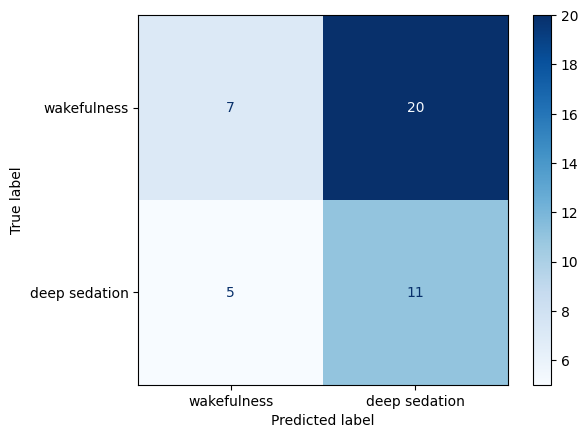

               precision    recall  f1-score   support

  wakefulness       0.58      0.26      0.36        27
deep sedation       0.35      0.69      0.47        16

     accuracy                           0.42        43
    macro avg       0.47      0.47      0.41        43
 weighted avg       0.50      0.42      0.40        43



In [43]:
from sklearn import svm 

SVC=svm.SVC(C=.1,gamma=.1,kernel='poly')
SVC.fit(x_train,y_train)

y_pred=SVC.predict(x_test)
print(accuracy_score(y_pred,y_test))
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['wakefulness','deep sedation'])
disp.plot(cmap='Blues')
plt.show()
print(classification_report(y_test,y_pred,target_names=['wakefulness','deep sedation']))

In [ ]:
# def f_importances(coef, names):
#   """
#   PLOTS all features by importance for linear SVM
#   """

#     imp = coef
#     imp,names = zip(*sorted(zip(imp,names)))
#     plt.barh(range(len(names)), imp, align='center')
#     plt.yticks(range(len(names)), names)
#     plt.show()

In [ ]:
# f_importances(SVC.coef_[0],features)

In [44]:
features=np.arange(5500)
features

array([   0,    1,    2, ..., 5497, 5498, 5499])

In [ ]:
pd.Series(abs(SVC.coef_[0]), index=features).nlargest(10).plot(kind='barh')

In [ ]:
#only works for linear SVC
#SVC.coef_ 

In [45]:
#cross validate data to determine best max_depth parameter
from sklearn import tree
# N=30 #largest max_depth
# training_scores=np.zeros(N)
# testing_scores=np.zeros(N)
# depths=np.arange(1,31)


# for d in range(1, 30):
#     T = tree.DecisionTreeClassifier(max_depth = d)
#     T.fit(x_train, y_train)
#     training_scores[d-1]=T.score(x_train,y_train)
#     testing_scores[d-1]=T.score(x_test,y_test)
# print(training_scores,testing_scores)
    
    
# fig, ax = plt.subplots(1, figsize = (10, 7))
    
# ax.scatter(depths,training_scores,color="black",label="training")
# ax.scatter(depths,testing_scores,color="firebrick",label="testing")    
# ax.set(xlabel = "Complexity (depth)", ylabel = "Performance (score)",ylim=(.73,1))
# ax.legend()

T = tree.DecisionTreeClassifier()

max_depth = range(1,15)
# Create the random grid
random_grid = {'max_depth': max_depth}
grid_search=GridSearchCV(T,param_grid=random_grid)
grid_search.fit(x_train,y_train)
grid_search.best_params_

{'max_depth': 6}

In [46]:
from sklearn import tree

T=tree.DecisionTreeClassifier(max_depth=6)
T.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=6)

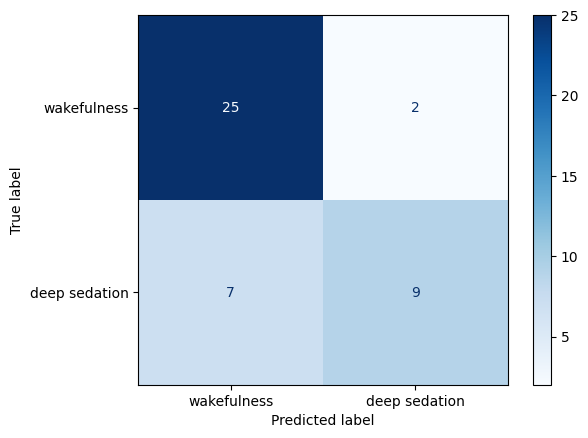

               precision    recall  f1-score   support

  wakefulness       0.78      0.93      0.85        27
deep sedation       0.82      0.56      0.67        16

     accuracy                           0.79        43
    macro avg       0.80      0.74      0.76        43
 weighted avg       0.79      0.79      0.78        43



In [47]:
y_pred=T.predict(x_test)
accuracy_score(y_pred,y_test)
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['wakefulness','deep sedation'])
disp.plot(cmap='Blues')
plt.show()
print(classification_report(y_test,y_pred,target_names=['wakefulness','deep sedation']))

In [48]:
from sklearn.neighbors import KNeighborsClassifier

#cross validate data to determine best max_depth parameter

# N=10 #largest max_depth
# training_scores=np.zeros(N)
# testing_scores=np.zeros(N)
# neighbors=np.arange(1,11)

# for d in range(1, 11):
#     knn = KNeighborsClassifier(n_neighbors = d)
#     knn.fit(x_train, y_train)
#     y_pred=knn.predict(x_test)
#     training_scores[d-1]=accuracy_score(y_pred,y_test)
#     testing_scores[d-1]=accuracy_score(y_pred,y_test)
    
# print(training_scores,testing_scores)
# fig, ax = plt.subplots(1, figsize = (10, 7))
    
# ax.scatter(neighbors,training_scores,color="black",label="training")
# ax.scatter(neighbors,testing_scores,color="firebrick",label="testing")    
# ax.set(xlabel = "Complexity (depth)", ylabel = "Performance (score)",ylim=(0,1))
# ax.legend()

KNN = KNeighborsClassifier()

n_neighbors = range(1,15)
# Create the random grid
random_grid = {'n_neighbors': n_neighbors}
grid_search=GridSearchCV(KNN,param_grid=random_grid)
grid_search.fit(x_train,y_train)
grid_search.best_params_

{'n_neighbors': 4}

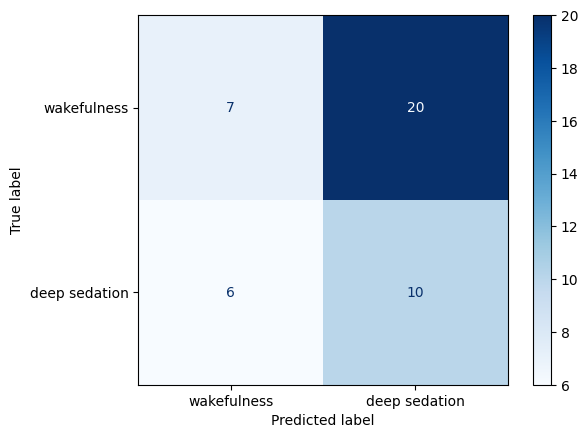

               precision    recall  f1-score   support

  wakefulness       0.54      0.26      0.35        27
deep sedation       0.33      0.62      0.43        16

     accuracy                           0.40        43
    macro avg       0.44      0.44      0.39        43
 weighted avg       0.46      0.40      0.38        43



In [49]:
#choose k=7
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=4)
knn.fit(x_train,y_train)
y_pred=knn.predict(x_test)
accuracy_score(y_pred,y_test)
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['wakefulness','deep sedation'])
disp.plot(cmap='Blues')
plt.show()
print(classification_report(y_test,y_pred,target_names=['wakefulness','deep sedation']))

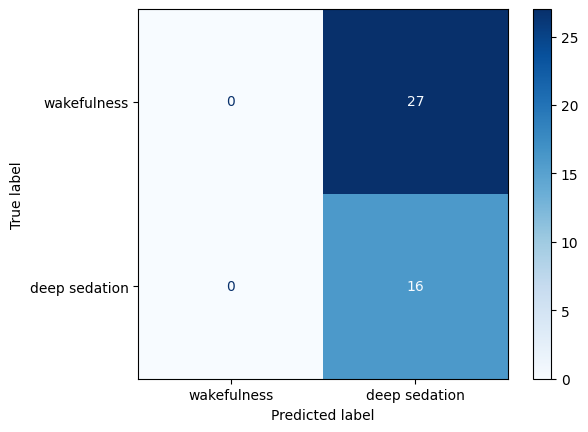

               precision    recall  f1-score   support

  wakefulness       0.00      0.00      0.00        27
deep sedation       0.37      1.00      0.54        16

     accuracy                           0.37        43
    macro avg       0.19      0.50      0.27        43
 weighted avg       0.14      0.37      0.20        43



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
GNB.fit(x_train, y_train)
y_pred=GNB.predict(x_test)
accuracy_score(y_pred,y_test)
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['wakefulness','deep sedation'])
disp.plot(cmap='Blues')
plt.show()
print(classification_report(y_test,y_pred,target_names=['wakefulness','deep sedation']))

In [51]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [90,100,115,130]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [2, 10, 15, 20]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
criterion = ['gini','entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}


RF = RandomForestClassifier()
grid_search=RandomizedSearchCV(RF,random_grid)
grid_search.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 10, 15, 20],
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [90, 100, 115, 130]})

In [52]:
grid_search.best_params_

{'n_estimators': 115,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 15,
 'criterion': 'gini'}

0.6976744186046512


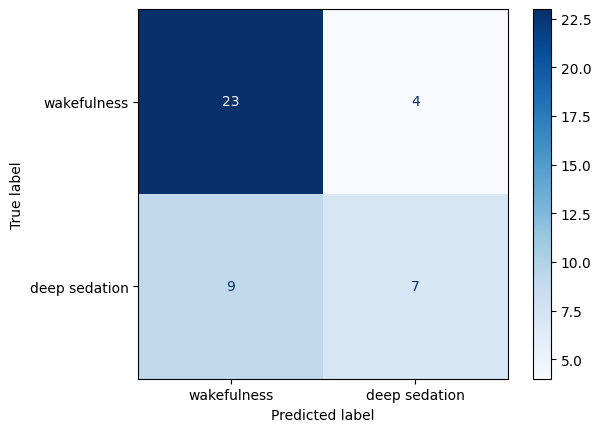

               precision    recall  f1-score   support

  wakefulness       0.72      0.85      0.78        27
deep sedation       0.64      0.44      0.52        16

     accuracy                           0.70        43
    macro avg       0.68      0.64      0.65        43
 weighted avg       0.69      0.70      0.68        43

[   0    1    2 ... 5497 5498 5499]


In [53]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion='gini',
                          max_depth=15,
                          max_features='log2',
                          min_samples_leaf=1,
                          min_samples_split=5,
                          n_estimators=115)
# RF=RandomForestClassifier(criterion='entropy',
#                           max_depth=10,
#                           max_features='auto',
#                           min_samples_leaf=4,
#                           min_samples_split=10,
#                           n_estimators=115)
RF.fit(x_train,y_train)
y_pred=RF.predict(x_test)

print(accuracy_score(y_pred,y_test))


cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['wakefulness','deep sedation'])
disp.plot(cmap='Blues')
plt.show()
print(classification_report(y_test,y_pred,target_names=['wakefulness','deep sedation']))
print(features)

In [54]:
features = RF.feature_importances_
pd.DataFrame(features).to_csv("HudetzHoldoutRF3features.csv")

In [ ]:
model.summary() #limit # of trainable parameters (conv2D provides limitations,takes less time than Dense layers would)

Let's see how our model does over epochs! 

In [ ]:
plt.plot(history.history["accuracy"],label='training')
plt.plot(history.history["val_accuracy"],label='validation')
plt.legend()

## Extracting Predictions

In [ ]:
y_pred,y_test

Let's see how our model did on the test data: 

In [ ]:
y_pred=model.predict(x_test)
y_pred

We'll plot these predicted labels along side the (true labels). 

In [ ]:
plt.figure(figsize=(10,4))
for i, num in enumerate([1, 3, 4, 5, 6, 11,14,16]):
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.reshape(x_test[num],(55,100)))
    lab=int(y_test[num])
    plt.xlabel(train_labels[int(y_pred[num])] + f" ({train_labels[lab]})")
plt.tight_layout()
plt.show()

# Generating Group Means





In [ ]:
all_data=np.concatenate([all_data,all_test_data])
all_labels=np.concatenate([all_labels,all_test_labels])

In [ ]:
wake=[]
unconscious=[]
recovery=[]

for i, label in enumerate(all_labels):
  if label==0:
    wake.append(all_data[i])
  elif label==1:
    unconscious.append(all_data[i])
  elif label==2:
    recovery.append(all_data[i]) # if exists in data breakdown

wake_mean = np.mean(np.array(wake),axis=0)
unconscious_mean = np.mean(np.array(unconscious),axis=0)
if len(recovery) != 0:
  recovery_mean = np.mean(np.array(recovery),axis=0)

In [ ]:
wake

In [ ]:
el1 = [item[0] for item in wake]
el1

# el2=[item[15] for item in unconscious]
# el2

# variance(el2)/variance(el1)

In [ ]:
stats.ttest_ind(el1,el2)

In [ ]:
ttest_ind_results = []

for i in (range(len(all_data[0]))):
  wake_i = [item[i] for item in wake]
  unconscious_i = [item[i] for item in unconscious]

  #T TEST ASSUMPTIONS: independent samples, random sampling, normal distribution -> mann whitney u test? 
  #independent or dependent?
  #t.test - welsh's or pooled (check variance of wake/unconscious), paired or no, FDR correction
  #equal var True (Student's), independent?, FDR correction
  #ASSESS SIGNIFICANCE - compare t tests? across all 1500 cols? (check robyn paper, IEEE paper) -> return sig cols? 
  #(is there a diff between cols)

  ttest_ind_results.append(stats.ttest_ind(wake_i,unconscious_i))

#print(sig_cols)


In [ ]:
pvals=[]

for result in ttest_ind_results:
  pvals.append(result[1])

In [ ]:
pvals

In [ ]:
from statsmodels.stats.multitest import fdrcorrection
adjustedps = fdrcorrection(pvals,alpha=0.1)

In [ ]:
adjustedps

In [ ]:
for i,val in enumerate(adjustedps[0]):
  if val==True:
    print(i)

In [ ]:
#visualize group mean STSPs

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(np.reshape(wake_mean,(55,100)))
plt.xlabel("wake")

plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(np.reshape(unconscious_mean,(55,100)))
plt.xlabel("unconscious")

plt.tight_layout()
plt.show()

# Visualizing Learned Features 

It's possible to define a separate model that allows us to study the features learned by the model. These are often called *activations*. We create this model by simply asserting that the model outputs are equal to the outputs of the first convolutional layer. For this we use the `models.Model` class rather than the `models.Sequential` class, which is more convenient but less flexible. 

It's possible to look at the activations at different levels of the model. Generally speaking, it is expected that the activations become more abstract as one goes higher up the model structure. 

In [ ]:
#only looking at outputs of first layer

activation_model=models.Model(inputs=SVC.input,outputs=SVC.layers[0].output)

Now we can compute the activations

In [ ]:
activations=activation_model.predict(train_images[0:10])

And visualize them! 

In [ ]:
k = 7

color_im = x_train[k:(k+1)]
convd = conv(color_im).numpy()

fig, axarr = plt.subplots(3, 3, figsize = (8, 6))

axarr[0, 0].imshow(color_im[0])
axarr[0,0].axis("off")
axarr[0,0].set(title = "Original")

i = 0
for ax in axarr.flatten()[1:]:
    ax.imshow(activations[k,:,:,i], cmap = "gray")
    i += 1
    ax.axis("off")
    ax.set(title = "Feature " + str(i))
    
plt.tight_layout()

Somewhat romantically, these activations might be interpreted as "how the algorithm looks at" the resulting image. That said, one must be careful of over-interpretation. Still, it looks like some of the features correspond to edge detection (like we saw above), while others correspond to highlighting different patches of colors, enabling, for example, separation of the foreground object from the background. 